In [23]:
import tushare as ts
import pandas as pd
import os
import time
import random
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class TushareProLite:
    def __init__(self, token, max_workers=2, min_interval=2.0):
        ts.set_token(token)
        self.pro = ts.pro_api()
        self.data_dir = 'tushare_pro_data'
        os.makedirs(self.data_dir, exist_ok=True)
        self.max_workers = max_workers  # 并行线程数
        self.min_interval = min_interval  # 每次请求间隔（秒）
        self.last_request_time = 0

    # ---------------- 安全调用 ----------------
    def safe_call(self, func, *args, **kwargs):
        for attempt in range(3):
            try:
                elapsed = time.time() - self.last_request_time
                if elapsed < self.min_interval:
                    time.sleep(self.min_interval - elapsed)
                self.last_request_time = time.time()
                time.sleep(random.uniform(0.5, 1.0))  # 随机延时
                return func(*args, **kwargs)
            except Exception as e:
                print(f"⚠️ 请求失败({attempt+1}/3): {e}, 等待 {5*(attempt+1)}s 重试...")
                time.sleep(5*(attempt+1))
        return None

    # ---------------- 获取稳定股票 ----------------
    def stable_stocks(self, min_years=1, include_industry=True):
        """
        返回稳定股票列表，并可选择获取行业信息
        只调用一次接口，避免限流。
        """
        path = os.path.join(self.data_dir, 'stable_stocks.csv')
        industry_path = os.path.join(self.data_dir, 'stable_stocks_industry.csv')

        # 1️⃣ 先尝试读取缓存
        if os.path.exists(path):
            df = pd.read_csv(path, dtype=str)
            print(f"✅ 从缓存加载 {len(df)} 只稳定股票")
            codes = df['ts_code'].tolist()

            if include_industry and os.path.exists(industry_path):
                df_ind = pd.read_csv(industry_path, dtype=str)
                print(f"✅ 从缓存加载行业信息")
                return codes, df_ind
            return codes

        # 2️⃣ 首次获取全部股票信息（一次性）
        df = self.safe_call(
            self.pro.stock_basic,
            exchange='',
            list_status='L',
            fields='ts_code,symbol,name,list_date,area,industry'
        )
        if df is None or df.empty:
            return [] if not include_industry else ([], pd.DataFrame())

        # 3️⃣ 筛选稳定股票
        start_threshold = (datetime.today() - timedelta(days=min_years*365)).strftime('%Y%m%d')
        stable_df = df[df['list_date'] <= start_threshold]

        # 4️⃣ 保存缓存
        stable_df.to_csv(path, index=False)
        print(f"✅ 首次获取 {len(stable_df)} 只稳定股票，已缓存")

        codes = stable_df['ts_code'].tolist()

        if include_industry:
            # 保存行业信息
            stable_df[['ts_code','name','industry','list_date']].to_csv(industry_path, index=False)
            print(f"✅ 已保存行业信息，共 {len(stable_df)} 条")
            return codes, stable_df[['ts_code','name','industry','list_date']]
        return codes

    # ---------------- 单股票日线 ----------------
    def _get_daily_single(self, ts_code, start_date='20170101', end_date=None):
        """获取单只股票日线数据（CSV缓存）"""
        end_date = end_date or datetime.today().strftime('%Y%m%d')
        csv_path = os.path.join(self.data_dir, f"{ts_code}.csv")

        # 已缓存直接读取
        if os.path.exists(csv_path):
            return pd.read_csv(csv_path, index_col=0, parse_dates=True)

        df = self.safe_call(self.pro.daily, ts_code=ts_code,
                            start_date=start_date, end_date=end_date,
                            fields='ts_code,trade_date,open,high,low,close,vol,amount')

        if df is None or df.empty:
            return pd.DataFrame()

        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df.set_index('trade_date', inplace=True)
        df.sort_index(inplace=True)
        df.rename(columns={'vol':'volume','amount':'money'}, inplace=True)
        df['factor'] = 1.0
        df['code'] = ts_code
        df = df[['code','open','high','low','close','volume','money','factor']]

        df.to_csv(csv_path)  # 保存CSV缓存
        return df

    # ---------------- 批量获取 ----------------
    def get_all_daily(self, stocks, force_update=False, batch_size=20, sleep_between_batches=60):
        all_data_path = os.path.join(self.data_dir, 'all_data_jq.csv')
        
        # -------------------- 已有总表直接读取 --------------------
        if os.path.exists(all_data_path) and not force_update:
            print(f"📂 已存在 all_data_jq.csv，直接从本地读取")
            df_all = pd.read_csv(all_data_path, index_col=0, parse_dates=True)
            return df_all

        # -------------------- 分批抓取缺失 CSV --------------------
        all_dfs = []
        total = len(stocks)
        
        for start in range(0, total, batch_size):
            batch = stocks[start:start+batch_size]
            print(f"🚀 抓取股票 {start+1}-{start+len(batch)} / {total}")
            
            to_fetch = []
            # 已缓存 CSV 的直接读取
            for code in batch:
                csv_path = os.path.join(self.data_dir, f"{code}.csv")
                if os.path.exists(csv_path) and not force_update:
                    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                    all_dfs.append(df)
                else:
                    to_fetch.append(code)
            
            # 并行抓取缺失 CSV
            if to_fetch:
                with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                    futures = {executor.submit(self._get_daily_single, code): code for code in to_fetch}
                    for future in tqdm(as_completed(futures), total=len(futures), desc="抓取中"):
                        code = futures[future]
                        try:
                            df = future.result()
                            if not df.empty:
                                all_dfs.append(df)
                        except Exception as e:
                            print(f"⚠️ {code} 获取失败: {e}")
            
            # 每批抓完等待
            if start + batch_size < total:
                print(f"⏳ 本批完成，等待 {sleep_between_batches} 秒再抓下一批...")
                time.sleep(sleep_between_batches)

        # -------------------- 汇总所有数据 --------------------
        if all_dfs:
            df_all = pd.concat(all_dfs, ignore_index=False).sort_index()
            df_all.to_csv(all_data_path)
            print(f"✅ 总数据保存到 all_data_jq.csv, shape={df_all.shape}")
        else:
            df_all = pd.DataFrame()
        
        return df_all


    # ---------------- 清洗数据 ----------------
    def clean_data_real_trading_days(self, data, min_coverage_ratio=0.95, plot_distribution=True):
        if data.empty:
            print("⚠️ 输入数据为空")
            return pd.DataFrame()

        trading_day_counts = data.groupby(data.index)['close'].count()
        max_count = trading_day_counts.max()
        print(f"📅 共有 {len(trading_day_counts)} 个交易日，单日最多 {max_count} 只股票有数据")

        # 绘图
        if plot_distribution:
            for exch, label in [('all', '全部'), ('sh', '上交所'), ('sz', '深交所')]:
                if exch == 'sh':
                    df_plot = data[data['code'].str.endswith('.SH')]
                elif exch == 'sz':
                    df_plot = data[data['code'].str.endswith('.SZ')]
                else:
                    df_plot = data.copy()

                if df_plot.empty:
                    continue

                stock_days = df_plot.groupby('code')['close'].count()

                plt.figure(figsize=(10,5))
                plt.hist(stock_days, bins=30, color='skyblue', edgecolor='black', alpha=0.8)
                plt.xlabel("交易天数")
                plt.ylabel("股票数量")
                plt.title(f"{label}股票交易天数分布（共 {len(stock_days)} 只股票）")
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()

                print(f"📊 {label}样本数: {len(stock_days)} 只股票")
                print(f"🧮 平均交易天数: {stock_days.mean():.1f}")
                print(f"📈 最大交易天数: {stock_days.max()}  |  最小交易天数: {stock_days.min()}")

        # 筛选覆盖率足够的股票
        stock_coverage = data.groupby('code')['close'].count() / len(trading_day_counts)
        keep_stocks = stock_coverage[stock_coverage >= min_coverage_ratio].index
        print(f"✅ 保留 {len(keep_stocks)} 只股票（覆盖率 ≥ {min_coverage_ratio*100:.1f}%）")

        if len(keep_stocks) == 0:
            print("⚠️ 无满足覆盖率要求的股票")
            return pd.DataFrame()

        data = data[data['code'].isin(keep_stocks)]
        all_dates = trading_day_counts.index

        def fill_group(df):
            df = df.reindex(all_dates)
            df['code'] = df['code'].ffill().bfill()
            numeric_cols = df.select_dtypes(include=['number']).columns
            df[numeric_cols] = df[numeric_cols].interpolate().ffill().bfill()
            return df

        clean_df = data.groupby('code', group_keys=False)[data.columns].apply(fill_group)
        clean_df.index.name = 'trade_date'
        clean_df.sort_index(inplace=True)
        print(f"✅ 清洗完成，最终 shape={clean_df.shape}")

        return clean_df


    # ---------------- 提取收盘价矩阵 ----------------
    def extract_close_matrix_real_trading_days(self, clean_df, save_npy=True, exchange='all'):
        """
        从清洗后的数据中提取收盘价矩阵
        参数:
            clean_df : DataFrame，必须包含 'code' 和 'close'
            save_npy : 是否保存为 npy 文件
            exchange : 选择市场类型
                    'all' - 所有股票
                    'sh'  - 仅上交所 (代码以 .SH 结尾)
                    'sz'  - 仅深交所 (代码以 .SZ 结尾)
        """
        if 'code' not in clean_df.columns or 'close' not in clean_df.columns:
            raise ValueError("输入数据必须包含 'code' 和 'close' 列")

        # ---------------- 按交易所筛选 ----------------
        exchange = exchange.lower()
        if exchange == 'sh':
            filtered_df = clean_df[clean_df['code'].str.endswith('.SH')]
            print(f"🏦 仅保留上交所股票，共 {filtered_df['code'].nunique()} 只")
        elif exchange == 'sz':
            filtered_df = clean_df[clean_df['code'].str.endswith('.SZ')]
            print(f"🏦 仅保留深交所股票，共 {filtered_df['code'].nunique()} 只")
        else:
            filtered_df = clean_df.copy()
            print(f"🏦 保留所有股票，共 {filtered_df['code'].nunique()} 只")

        if filtered_df.empty:
            print("⚠️ 筛选后无股票数据")
            return None, None, None, None

        # ---------------- 生成收盘价矩阵 ----------------
        close_df = filtered_df.pivot_table(index='code', columns=filtered_df.index, values='close')
        codes = close_df.index.tolist()
        dates = close_df.columns.tolist()
        P = close_df.to_numpy()

        # ---------------- 可选保存 ----------------
        if save_npy:
            suffix = exchange if exchange in ['sh', 'sz'] else 'all'
            np.save(os.path.join(self.data_dir, f"close_matrix_{suffix}.npy"), P)
            np.save(os.path.join(self.data_dir, f"codes_{suffix}.npy"), np.array(codes))
            np.save(os.path.join(self.data_dir, f"dates_{suffix}.npy"), np.array(dates))
            print(f"💾 已保存收盘价矩阵: {P.shape} → close_matrix_{suffix}.npy")
            print(f"💾 已保存股票代码列表: {len(codes)} 条 → codes_{suffix}.npy")
            print(f"💾 已保存日期列表: {len(dates)} 条 → dates_{suffix}.npy")

        return close_df, P, codes, dates


In [ ]:
token = "65209d394f51051f94f8a9eeeb3396048121ecf94080eda0e33d06e5"
lite = TushareProLite(token, max_workers=2, min_interval=2.0)

# 1 获取稳定股票
stocks = lite.stable_stocks(min_years=1,include_industry = False)

# 2 批量获取日线
df_all = lite.get_all_daily(stocks, batch_size=1000, sleep_between_batches=60)

# 3 清洗
clean_df = lite.clean_data_real_trading_days(df_all)

# 4 提取收盘价矩阵
close_df, P, codes, dates = lite.extract_close_matrix_real_trading_days(clean_df)



✅ 从缓存加载 5332 只稳定股票


' # 2️⃣ 批量获取日线\ndf_all = lite.get_all_daily(stocks, batch_size=1000, sleep_between_batches=60)\n\n# 3️⃣ 清洗\nclean_df = lite.clean_data_real_trading_days(df_all)\n\n# 4️⃣ 提取收盘价矩阵\nclose_df, P, codes, dates = lite.extract_close_matrix_real_trading_days(clean_df) '

In [25]:
token = "65209d394f51051f94f8a9eeeb3396048121ecf94080eda0e33d06e5"
td = TushareProLite(token)

# 1️⃣ 获取稳定股票
stocks = td.stable_stocks(min_years=1)
start_date = '20170101'
# 2️⃣ 获取日线数据（聚宽格式）
#all_data = td.get_all_daily(stocks[:], start_date=start_date)  # 测试前20只



✅ 从缓存加载 5332 只稳定股票


📅 共有 2138 个交易日，单日最多 5329 只股票有数据


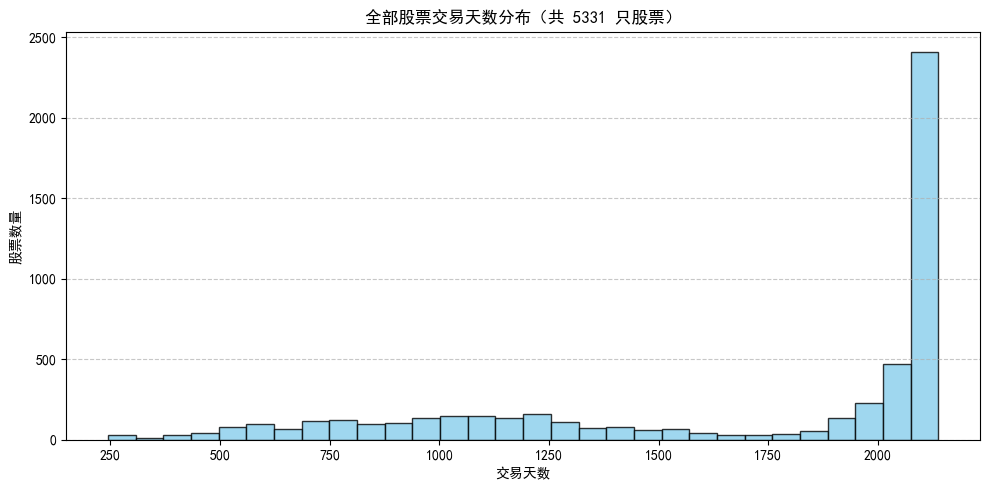

📊 全部样本数: 5331 只股票
🧮 平均交易天数: 1688.3
📈 最大交易天数: 2138  |  最小交易天数: 244


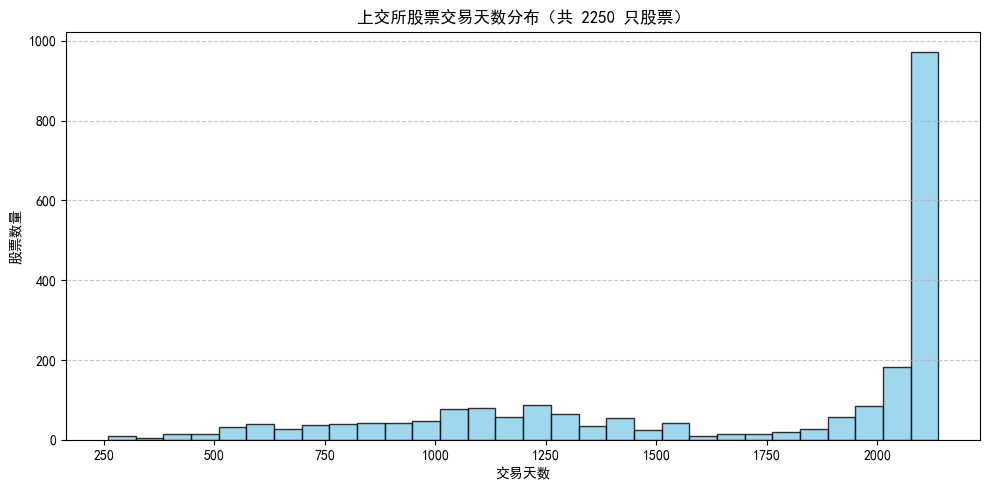

📊 上交所样本数: 2250 只股票
🧮 平均交易天数: 1677.1
📈 最大交易天数: 2138  |  最小交易天数: 259


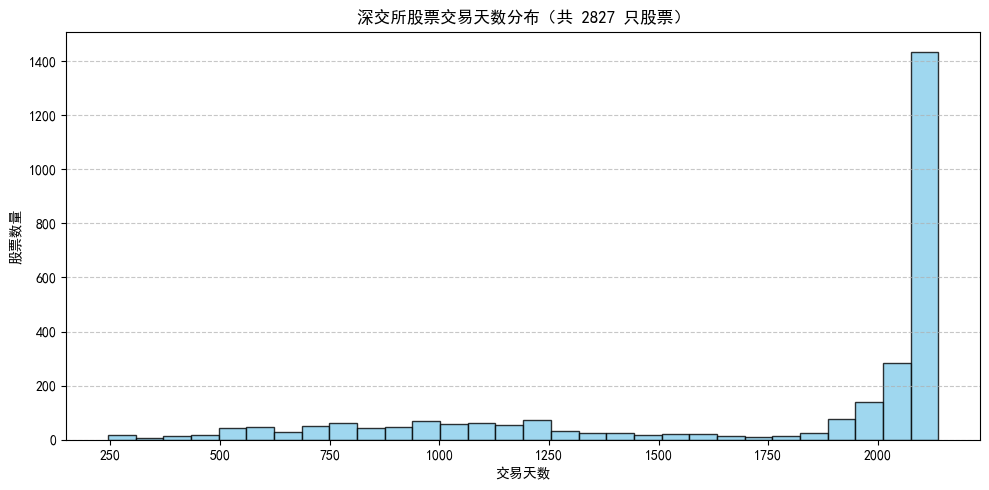

📊 深交所样本数: 2827 只股票
🧮 平均交易天数: 1757.0
📈 最大交易天数: 2138  |  最小交易天数: 244
✅ 保留 1230 只股票（覆盖率 ≥ 99.9%）
✅ 清洗完成，最终 shape=(2629740, 2)


In [26]:
pro_lite = TushareProLite(token="65209d394f51051f94f8a9eeeb3396048121ecf94080eda0e33d06e5")
data = pd.read_csv('tushare_pro_data/all_data_jq.csv', parse_dates=True, index_col=0)
df = data[['code', 'close']].copy()
clean_df = pro_lite.clean_data_real_trading_days(df, min_coverage_ratio=0.999, plot_distribution=True)

In [27]:
close_df, P, codes, dates = pro_lite.extract_close_matrix_real_trading_days(clean_df, exchange='sh')

print(P.shape)       # (N, L) 行（N）：每一行对应一个股票，列（L）：每一列对应一个交易日
print(len(codes), "stocks")
print(len(dates), "trading days")
print("Example codes:", codes[:5])
print("Example dates:", dates[:5])
print(P)



🏦 仅保留上交所股票，共 532 只
💾 已保存收盘价矩阵: (532, 2138) → close_matrix_sh.npy
💾 已保存股票代码列表: 532 条 → codes_sh.npy
💾 已保存日期列表: 2138 条 → dates_sh.npy
(532, 2138)
532 stocks
2138 trading days
Example codes: ['600000.SH', '600004.SH', '600007.SH', '600011.SH', '600015.SH']
Example dates: [Timestamp('2017-01-03 00:00:00'), Timestamp('2017-01-04 00:00:00'), Timestamp('2017-01-05 00:00:00'), Timestamp('2017-01-06 00:00:00'), Timestamp('2017-01-09 00:00:00')]
[[16.3  16.33 16.3  ... 13.03 12.97 12.98]
 [14.29 14.39 14.35 ...  9.53  9.6   9.56]
 [17.43 17.67 17.42 ... 20.59 20.58 20.38]
 ...
 [33.27 32.93 31.88 ...  9.19  9.29  9.25]
 [37.28 37.4  36.42 ... 17.48 17.46 18.04]
 [ 3.75  3.8   3.8  ... 15.54 15.9  16.78]]


In [28]:
print(clean_df.iloc[1])

code     002671.SZ
close         12.1
Name: 2017-01-03 00:00:00, dtype: object
